# Deep Hedging of Green PPAs

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel
import numpy as np
from scipy.special import comb

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/doeltz/doeltz/development/RiVaPy/rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
2023-06-22 17:57:18.177259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-22 17:57:18.177279: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Residual Demand Forward Model

In [2]:
days = 10
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1]]

In [3]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, x_volatility=1.4 , x_mean_reversion_speed=2.0, 
                                      power_name= 'Power_Germany')

In [5]:
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))
model_result = model.simulate(timegrid, rnd, expiries=forward_expiries, 
                                 initial_forecasts={'Onshore': [0.8],
                                                          'Offshore': [0.6]},
                                power_fwd_prices = [100])

In [6]:
model_result.keys()

{'Offshore_FWD0', 'Onshore_FWD0', 'Power_Germany_FWD0', 'Wind_Germany_FWD0'}

# PPA Hedging

In [7]:
class Repo:
    def __init__(self, repo_dir):
        self.repo_dir = repo_dir
        self.results = {}
        with open(repo_dir+'/hedge_results.json','r') as f:
            self.results = json.load(f)
            
    def run_hedge_experiment(self, val_date, ppa_spec, model, **kwargs):
        params = {}
        params['ppa_spec'] = ppa_spec.to_dict()
        params['ppa_spec_hash'] = ppa_spec.hash()
        params['model'] = model.to_dict()
        params['model_hash'] = model.hash()
        params['pricing_param'] = kwargs
        hash_key = FactoryObject.hash_for_dict(params)
        #if hash_key in results:
        
        pricing_result =  GreenPPADeepHedgingPricer.price(val_date, 
                                      ppa_spec, 
                                      model,
                                    **kwargs)
        return pricing_results

from rivapy.tools.interfaces import FactoryObject

def compute_pnl_figures(pricing_results):
    pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)
    return {'mean': pnl.mean(), 'var': pnl.var(), '1%':np.percentile(pnl,1), '99%': np.percentile(pnl,1)}

def compute_pnl(pricing_results):
    return pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)

In [8]:
val_date = dt.datetime(2023,1,1)
strike = 0.3 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [9]:
pricing_result =  GreenPPADeepHedgingPricer.price(val_date, 
                                      spec, 
                                      model,
                                    model, 
                                        initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                            'Offshore': [0.6,0.6,0.6,0.6]},
                                       power_fwd_prices=[1.0],
                                        forecast_hours=[10, 14, 18],
                                        additional_states=['Offshore'],
                                          depth=3, nb_neurons=32, n_sims=100_000, 
                                        regularization=0.0,
                                          epochs=20, verbose=1,
                                        tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                        initial_lr=5e-4,
                                        decay_steps=8_000,
                                          batch_size=100, decay_rate=0.8, seed=42)

TypeError: price() got multiple values for argument 'initial_forecasts'

In [11]:
model = DeepHedgeModel.load('depp')

In [37]:
pricing_results = run_hedge_experiment(val_date, 
                                      spec, 
                                      model, 
                                        initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                            'Offshore': [0.6,0.6,0.6,0.6]},
                                       power_fwd_prices=[1.0],
                                        forecast_hours=[10, 14, 18],
                                        additional_states=['Offshore'],
                                          depth=3, nb_neurons=32, n_sims=100_000, 
                                        regularization=0.0,
                                          epochs=20, verbose=1,
                                        tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                        initial_lr=5e-4,
                                        decay_steps=8_000,
                                          batch_size=100, decay_rate=0.8, seed=42)

/home/doeltz/doeltz/development/RiVaPy/rivapy/tools/datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


Epoch 1/20
1000/1000 [==============================] - 7s 2ms/step - loss: 1.0018e-04
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.8207e-05
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.9591e-05
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.8396e-05
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.7541e-05
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.6689e-05
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.5947e-05
Epoch 8/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.6003e-05
Epoch 9/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.4701e-05
Epoch 10/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.4335e-05
Epoch 11/20
1000/1000 [==============================] - 2s 2ms/step - loss: 7.4303e-05
Epoch 12/20
1000/1000 [==================

In [39]:
pricing_results.paths.keys()
#ttm

dict_keys(['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0'])

8/8 [==============================] - 0s 1ms/step


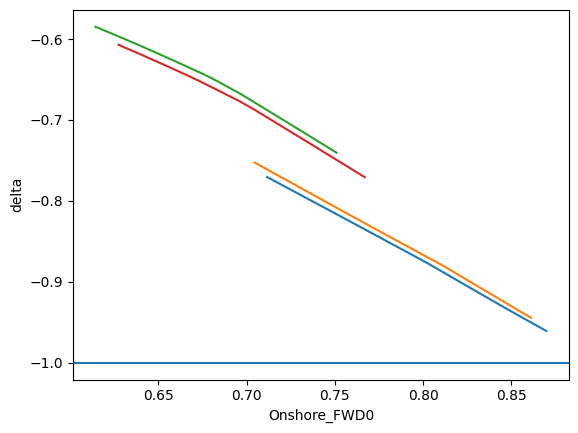

In [85]:
t = 48
p=10.0
projection = np.linspace(0.9,1.1, 250)
projected_key = 'Onshore_FWD0'
for selected in [2,5,100,400]:
#selected = 2
    #key = 'Power_Germany_FWD0'
    #x = np.percentile(pricing_results.paths[key][-1,:],p)
    #selected = np.abs(x-pricing_results.paths[key][-1,:]).argmin()
    paths = {}

    T = pricing_results.hedge_model.timegrid[-1]
    ttm = (T-pricing_results.hedge_model.timegrid[t])/T
    for k,v in pricing_results.paths.items():
        if k == projected_key:
            paths[k] = projection*v[t,selected]
            x = projection*v[t,selected]
        else:
            paths[k] = np.full(shape=(projection.shape[0]), fill_value=v[t,selected])
    delta = pricing_results.hedge_model.compute_delta(paths, ttm)   

    plt.plot(x, delta)
plt.xlabel(projected_key)
plt.axhline(-1.0)
plt.ylabel('delta');

## Path Plots

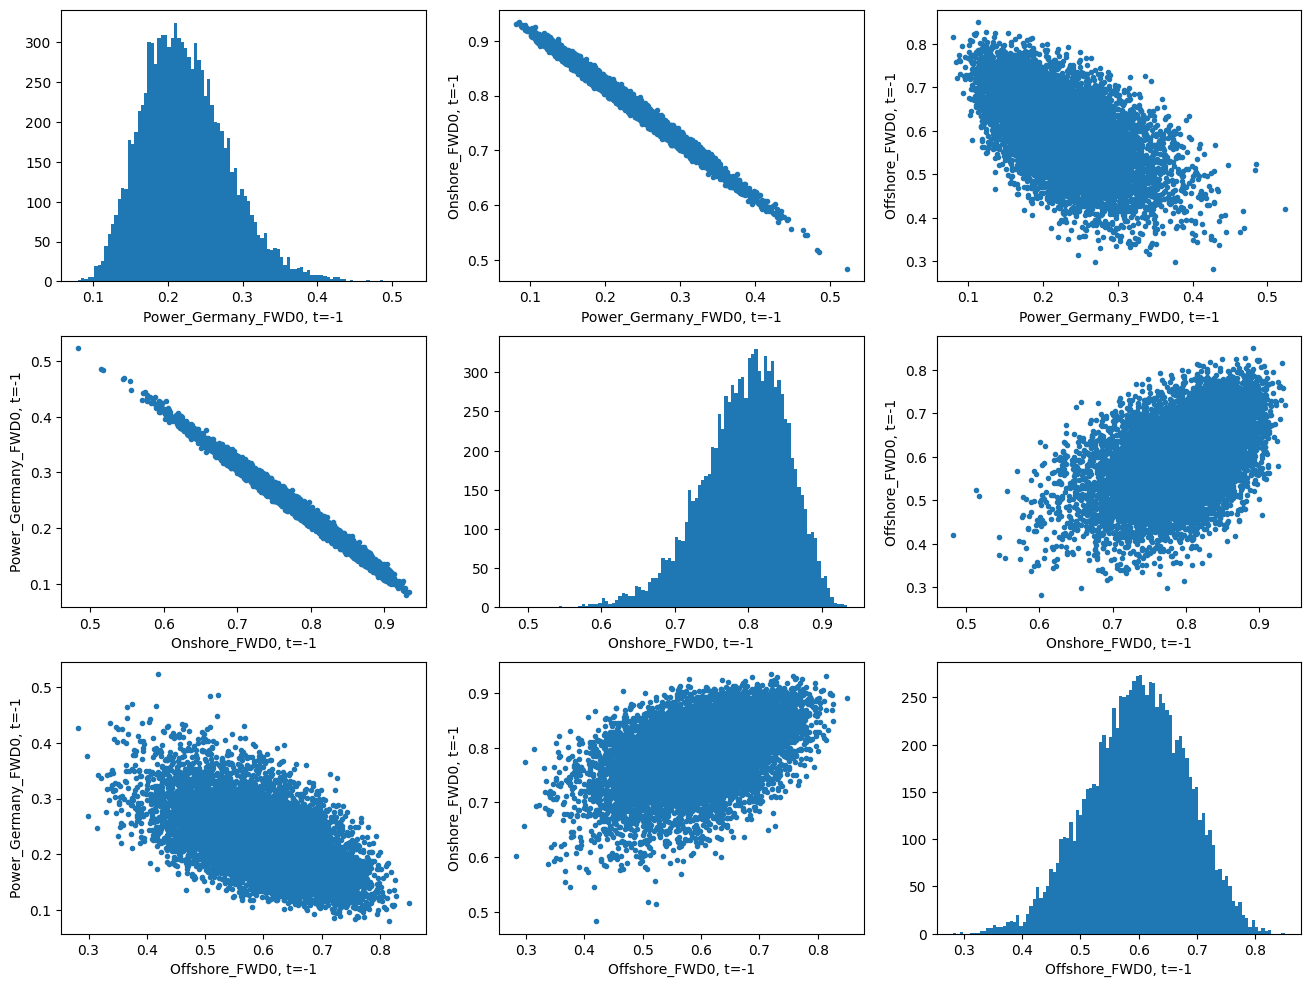

In [67]:
t = -1
plt.figure(figsize=(16,12))
n_x = 3
n_y = 3
i=1
for k,v in pricing_results.paths.items():
    for l,w in pricing_results.paths.items():
        plt.subplot(n_x,n_y,i)
        if k==l:
            plt.hist(v[t,:], bins=100)
            plt.xlabel(k+', t='+str(t))
        else:
            plt.plot(v[t,:], w[t,:], '.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(l+', t='+str(t))
        i += 1

## Hedge PnL Distribution

313/313 [==============================] - 8s 4ms/step


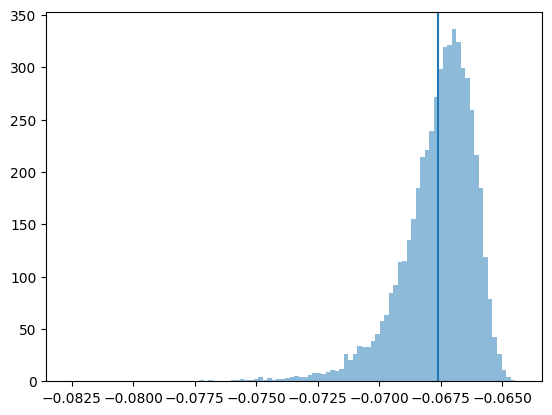

In [12]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)

#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.axvline(pnl.mean())
plt.hist(pnl,bins=100, alpha=0.5, density=True);

## Delta Plots

313/313 [==============================] - 1s 2ms/step


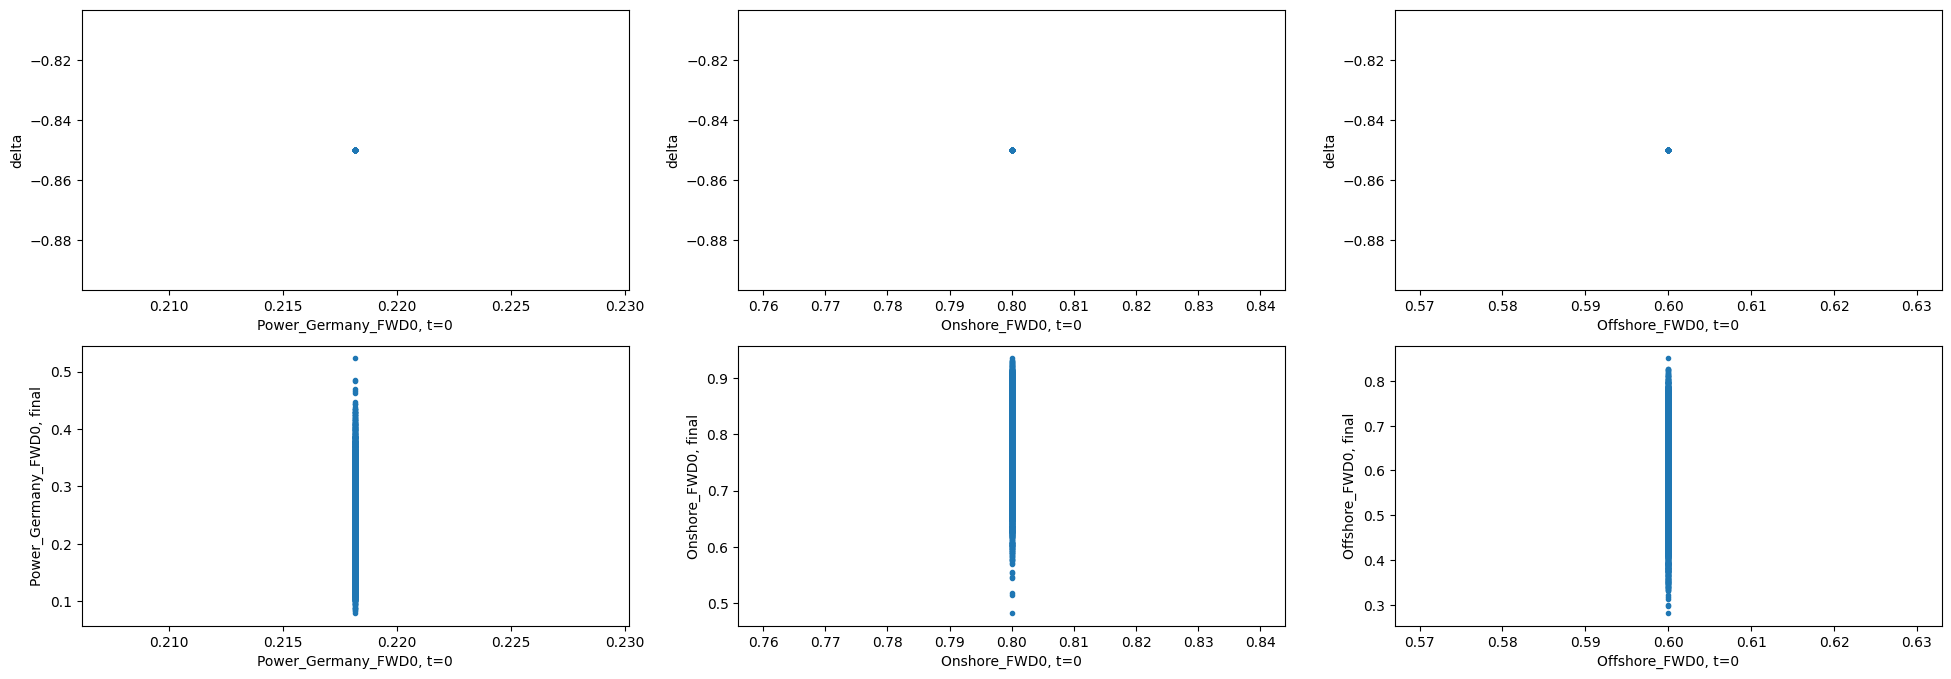

In [64]:
t = 0
n_x = 2
n_y = 3
plt.figure(figsize=(24,8))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1